In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Simple Beam Models

In [2]:
#nbx --fname=src/BeamModels.jl --jl_module=BeamModels
using Colors, Plots
col = palette(:default);
using LinearAlgebra: norm

```julia
    p_occ = beam_model(x, z; zmax=Inf, sig=0.5, res=0.1, 
                     free=0.0, prior=0.5, occ=1.)
```
Implementation of the function $p(\text{occ} \mid 𝑥,𝑧)$.

Given a measurement $z$ from one of the simulated range sensors, we would like to compute 
the probability of a cell at postion $x$ along the beam to be occupied:

$$
    p( \text{occ} \mid x, z) = \int p( \text{occ} \mid x, z') \cdot p( z' \mid z)  dz'.
$$

The first term of the integrand is the desired probability but knowing the ground truth $z'$, i.e. 
assuming a noise-free scenario.

In [3]:
#nbx
using SpecialFunctions: erf
normalcdf(x, mu=0.0, sig=1.0) = (1+erf((x-mu)/sig*sqrt(2)))/2

raw"""
    p_occ = beam_model(x, z; zmax=Inf, sig=0.5, res=0.1, 
                     free=0.0, prior=0.5, occ=1.)

Implementation of the function $p(\text{occ} \mid 𝑥,𝑧)$.

Given a measurement $z$ from one of the simulated range sensors, we would like to compute 
the probability of a cell at postion $x$ along the beam to be occupied:

$$
    p( \text{occ} \mid x, z) = \int p( \text{occ} \mid x, z') \cdot p( z' \mid z)  dz'.
$$

The first term of the integrand is the desired probability but knowing the ground truth $z'$, i.e. 
assuming a noise-free scenario.
"""
function beam_model(x, z; zmax=Inf, sig=0.5, res=0.1, 
                          free=0.0, prior=0.5, occ=1.)
    
    if zmax <= z; return x < zmax ? free : prior; end;
    if zmax <= x; return prior; end;

    x = clamp(x, res/2, zmax-res/2)
    
    x1 = x - res/2
    x2 = x + res/2
    
    c = normalcdf(zmax, z, sig) - normalcdf(0.0, z, sig)
    
    v  = 0.0
    v += prior*(normalcdf(  x1, z, sig) - normalcdf(0.0, z, sig))
    v += occ  *(normalcdf(  x2, z, sig) - normalcdf( x1, z, sig))
    v += free *(normalcdf(zmax, z, sig) - normalcdf( x2, z, sig))
    
    return v/c
end

beam_model (generic function with 1 method)

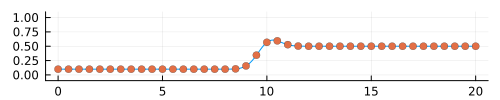

In [27]:
zmax = 100
z   = 10.
res = .5
sig = res
free, prior, occ = 0.1, 0.5, 1.0

xs = 0:0.1:min(zmax, 20)
ys = beam_model.(xs, z; zmax=zmax, sig=sig, res=res, free=free, prior=prior, occ=occ)
xs′ = 0:res:min(zmax, 20)
ys′ = beam_model.(xs′, z; zmax=zmax, sig=sig, res=res, free=free, prior=prior, occ=occ)
# ------
plot(size=(500,100), ylim=(-0.1,1.1), legend=nothing)
plot!(xs, ys)
scatter!(xs′, ys′)

## Inverse sensor in a 2d-cone

In [64]:
#nbx
bump(x, w) = (cos(clamp(x/w,-1,1)*π) + 1)/2

bump (generic function with 1 method)

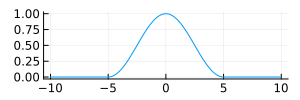

In [42]:
x = collect(-10:0.1:10)
w = 5
# -----------------------
plot(x, bump.(x, w), size=(300,100), legend=nothing)

In [43]:
#nbx
raw"""
    beam_model_cone(x, z; zmax=Inf, sig=0.5, res=0.1, 
                     free=0.0, prior=0.5, occ=1.)

...
"""
function beam_model_cone(x, z; amax=10/180*π ,zmax=Inf, sig=1.5, res=1., 
                              free=0.0, prior=0.5, occ=1.)
    
    a = atan(x[2], x[1])
    if abs(a) >= amax 
        return prior; 
    end
    
    da = bump(a, amax)
    return beam_model(norm(x), z; zmax=zmax, sig=sig, res=res, 
                            free=da*free + (1-da)*prior, prior=prior, occ=da*occ + (1-da)*prior)
end

beam_model_cone (generic function with 1 method)

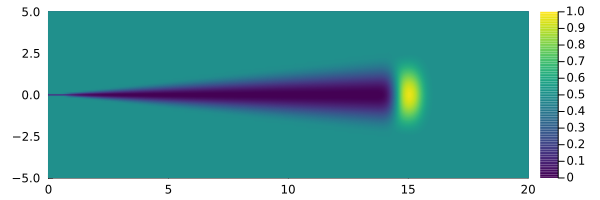

In [44]:
res = 1.
contour_func = (x1,x2) -> beam_model_cone([x1;x2], 15.0, amax=10/180*π, zmax=20, 
                                      sig=res/2, res=res, free=0.0, prior=0.5, occ=1.0);
# -----------------------------------
plot(
    contour(0.0:0.1:20, -5.:0.1:5, contour_func, fill=true, levels=0:0.01:1.0,
            linewidth=0.0, clim=(0,1),  c=:viridis, colorbar=true), 
size=(600,200))